In [1]:
import pandas as pd
import numpy as np
import unittest
import math

# **Homemade k-nearest neighbors Algorithm**

## *Elias Khan*

In my CPSC 330 class for my Data Science minor at UBC, we often go over different data science algorithms used for prediction. I started to wonder how complicated it would be to write an algorithm myself. When we got to the topic of the k-nearest neighbors algorithm, I decided it would be a good chance to try it out. 

I thought I’d write a simplified version of the algorithm to classify data using just two features, since higher dimensions seemed more complicated. I also decided to predict a binary variable and only used odd numbers for \(k\) to avoid dealing with ties between categories.

&nbsp;

The first thing I did was load a toy dataset from my CPSC 330 class to find variables that would be easy to make predictions with. I ended up choosing the feature variables `lab3` and `quiz1`, as they seemed like the best fit. When looking at the figure below, it looked like there was a pattern where some areas had more of certain types of data, but still enough variety to keep it interesting.

In [2]:
toy_df= pd.read_csv("/Users/elias/silly little idea/quiz2-grade-toy-classification.csv")
toy_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+


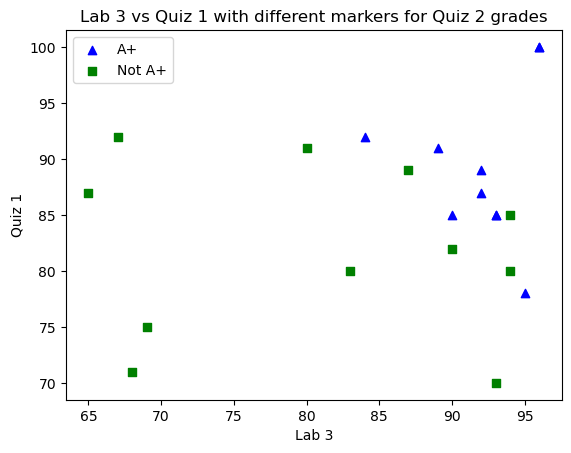

In [3]:
import matplotlib.pyplot as plt
plt.scatter(toy_df[toy_df['quiz2'] == "A+"]['lab3'], toy_df[toy_df['quiz2'] == "A+"]['quiz1'], 
            marker='^', label='A+', color='blue')

plt.scatter(toy_df[toy_df['quiz2'] != "A+"]['lab3'], toy_df[toy_df['quiz2'] != "A+"]['quiz1'], 
            marker='s', label='Not A+', color='green')

plt.xlabel('Lab 3')
plt.ylabel('Quiz 1')
plt.title('Lab 3 vs Quiz 1 with different markers for Quiz 2 grades')

plt.legend()

plt.show()

After loading the data and finding some good values to test the function on, I started creating the necessary functions for the algorithm.

The first function I wrote calculates the Euclidean distance between two points in the form `(x, y)`. This function is essential to the algorithm because we need to calculate the distances from the point we're trying to predict to all the other points in the dataset.

In [4]:
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

# Test case 1: Distance between the same point should be 0
assert euclidean_distance((0, 0), (0, 0)) == 0, "Test case 1 failed"

# Test case 2: Distance between (0, 0) and (3, 4) should be 5 (3-4-5 triangle)
assert euclidean_distance((0, 0), (3, 4)) == 5, "Test case 2 failed"

# Test case 3: Distance between (-1, -1) and (-4, -5) should be 5
assert euclidean_distance((-1, -1), (-4, -5)) == 5, "Test case 3 failed"

# Test case 4: Distance between floating point numbers (1.5, 2.5) and (3.5, 6.5)
assert math.isclose(euclidean_distance((1.5, 2.5), (3.5, 6.5)), 4.4721, rel_tol=1e-4), "Test case 4 failed"

# Test case 5: Distance between (1, -2) and (-2, 2) should be 5
assert math.isclose(euclidean_distance((1, -2), (-2, 2)), 5, rel_tol=1e-4), "Test case 5 failed"

print("All test cases passed!")

All test cases passed!


*NOTE:* I utilized chatGPT to test the functions that I wrote to insure that I didn't miss any cases that would make my code not function further down the line.

&nbsp;

The next function I created is a logical extension of the first. The function `find_distances_df(point, df, x_col, y_col)` lists all the distances from the given point to every point in a chosen dataset, while preserving their index. This is important because we'll need to know the class of the closest neighbors later on.

In [5]:
def find_distances_df(point, df, x_col, y_col):
    distances = []
    for index, row in df.iterrows():
        data_point = (row[x_col], row[y_col])
        distance = euclidean_distance(point, data_point)
        distances.append((index, distance))
    return distances

data = {
    'latitude': [3, 1, -3, 1.5],
    'longitude': [4, 1, -4, 2.5]
}
df = pd.DataFrame(data)

# Test case 1: Distance from (0, 0) to each point in the DataFrame using 'latitude' and 'longitude'
result = find_distances_df((0, 0), df, 'latitude', 'longitude')
expected_result = [(0, 5.0), (1, math.sqrt(2)), (2, 5.0), (3, math.sqrt(1.5**2 + 2.5**2))]
assert result == expected_result, f"Test case 1 failed: {result}"

# Test case 2: Distance from (1, 1) to each point in the DataFrame using 'latitude' and 'longitude'
result = find_distances_df((1, 1), df, 'latitude', 'longitude')
expected_result = [(0, math.sqrt((3 - 1) ** 2 + (4 - 1) ** 2)),
                   (1, 0.0),
                   (2, math.sqrt((1 - (-3)) ** 2 + (1 - (-4)) ** 2)),
                   (3, math.sqrt((1.5 - 1) ** 2 + (2.5 - 1) ** 2))]
assert result == expected_result, f"Test case 2 failed: {result}"

# Test case 3: Distance from (3, 4) to the points in the DataFrame using 'latitude' and 'longitude'
result = find_distances_df((3, 4), df, 'latitude', 'longitude')
expected_result = [(0, 0.0), (1, math.sqrt((3 - 1) ** 2 + (4 - 1) ** 2)),
                   (2, math.sqrt((3 - (-3)) ** 2 + (4 - (-4)) ** 2)),
                   (3, math.sqrt((3 - 1.5) ** 2 + (4 - 2.5) ** 2))]
assert result == expected_result, f"Test case 3 failed: {result}"

print("All test cases passed!")

All test cases passed!


The next function, `n_smallest_distances(lod, n)`, sorts the data from smallest to largest and selects the `n` smallest points to store in a new list. I had some trouble sorting the data in the `(index, distance)` format, so I consulted ChatGPT to help me sort the data, which allowed me to take the `n` smallest distances.

In [6]:
def n_smallest_distances(lod, n):
    n_smallest_points = sorted(lod, key=lambda x: x[1])[:n]
    return n_smallest_points

# Test case 1: Normal case where n is smaller than the list length
lod = [(0, 5), (1, 3), (2, 1), (3, 9), (4, 7)]
n = 3
result = n_smallest_distances(lod, n)
expected_result = [(2, 1), (1, 3), (0, 5)]  # The 3 smallest distances with their indices
assert result == expected_result, f"Test case 1 failed: {result}"

# Test case 2: n equals the length of the list
lod = [(0, 4), (1, 6), (2, 2), (3, 8), (4, 1)]
n = 5
result = n_smallest_distances(lod, n)
expected_result = [(4, 1), (2, 2), (0, 4), (1, 6), (3, 8)]  # The sorted list by distance
assert result == expected_result, f"Test case 2 failed: {result}"

# Test case 3: n is larger than the list length
lod = [(0, 7), (1, 3), (2, 9)]
n = 5
result = n_smallest_distances(lod, n)
expected_result = [(1, 3), (0, 7), (2, 9)]  # The entire list sorted by distance
assert result == expected_result, f"Test case 3 failed: {result}"

# Test case 4: n is 0 (expecting an empty list)
lod = [(0, 8), (1, 2), (2, 4), (3, 1)]
n = 0
result = n_smallest_distances(lod, n)
expected_result = []  # No elements should be returned
assert result == expected_result, f"Test case 4 failed: {result}"

# Test case 5: All elements have the same distance
lod = [(0, 5), (1, 5), (2, 5), (3, 5), (4, 5)]
n = 3
result = n_smallest_distances(lod, n)
expected_result = [(0, 5), (1, 5), (2, 5)]  # The first 3 identical elements
assert result == expected_result, f"Test case 5 failed: {result}"

print("All test cases passed!")

All test cases passed!


The function `most_common_target(lod, df, target_col)` checks the target column in the closest neighbors and determines which target value is the most common. This helps us assign a classification in the next function.

In [7]:
from collections import Counter

def most_common_target(lod, df, target_col):
    target_values = []
    for index, _ in lod:
        target_values.append(df.iloc[index][target_col])
    most_common = Counter(target_values).most_common(1)[0][0]
    return most_common

# Sample DataFrame for testing
data = {
    'latitude': [3, 1, -3, 1.5, 5],
    'longitude': [4, 1, -4, 2.5, 6],
    'target': ['A', 'B', 'A', 'A', 'C']  # Target column to find the most common value
}
df = pd.DataFrame(data)

# Test case 1: Clear majority in target column
lod = [(0, 5), (1, 3), (2, 1)]  # Indices correspond to rows in df
result = most_common_target(lod, df, 'target')
expected_result = 'A'  # 'A' appears twice in the corresponding rows
assert result == expected_result, f"Test case 1 failed: {result}"

# Test case 2: All target values are the same
lod = [(0, 5), (2, 1), (3, 4)]  # Indices correspond to rows in df
result = most_common_target(lod, df, 'target')
expected_result = 'A'  # All rows have 'A' as the target
assert result == expected_result, f"Test case 2 failed: {result}"

# Test case 3: No clear majority, tied target values
lod = [(0, 5), (1, 3), (4, 2)]  # Indices correspond to rows in df
result = most_common_target(lod, df, 'target')
expected_result = 'A'  # 'A' and 'C' appear once, 'A' appears first (alphabetical tie-breaker not explicit)
assert result == expected_result, f"Test case 3 failed: {result}"

# Test case 4: Only one data point in the list
lod = [(4, 2)]  # Only one point
result = most_common_target(lod, df, 'target')
expected_result = 'C'  # Only 'C' is present
assert result == expected_result, f"Test case 4 failed: {result}"

# Test case 5: Empty list of distances
lod = []  # Empty list
try:
    result = most_common_target(lod, df, 'target')
    assert False, "Test case 5 failed: should have raised an exception"
except IndexError:
    pass  # Expected to raise an IndexError as there are no elements in the list

print("All test cases passed!")


All test cases passed!


The final function, `classify_data_point(df, target, point, x_col, y_col, n)`, combines all the helper functions we've created to classify a given point.

In [8]:
def classify_data_point(df, target, point, x_col, y_col, n):
    lod = find_distances_df(point, df, x_col, y_col)
    neighbors = n_smallest_distances(lod, n)
    most_common = most_common_target(neighbors, df, target)
    return most_common
    
# Test case 1: Normal case with 3 neighbors, expecting 'A'
point = (0, 0)
n = 3
result = classify_data_point(df, 'target', point, 'latitude', 'longitude', n)
expected_result = 'A'  # 'A' appears most frequently among the 3 closest points
assert result == expected_result, f"Test case 1 failed: {result}"

# Test case 2: Only 1 neighbor, expecting that neighbor's target value
n = 1
result = classify_data_point(df, 'target', point, 'latitude', 'longitude', n)
expected_result = 'B'  # The closest point to (0,0) is at index 1, which has target 'B'
assert result == expected_result, f"Test case 2 failed: {result}"

# Test case 3: n is larger than the number of points, expecting most common target in all points
n = 10  # Larger than the total number of points in df
result = classify_data_point(df, 'target', point, 'latitude', 'longitude', n)
expected_result = 'A'  # 'A' appears most frequently in the entire dataset
assert result == expected_result, f"Test case 3 failed: {result}"

# Test case 4: No neighbors (n = 0), should raise an IndexError
n = 0
try:
    result = classify_data_point(df, 'target', point, 'latitude', 'longitude', n)
    assert False, "Test case 4 failed: should have raised an exception"
except IndexError:
    pass  # Expected to raise IndexError due to empty list of neighbors

# Test case 5: Tied target values, expecting 'A' (based on Counter's tie-breaking)
df_tied = pd.DataFrame({
    'latitude': [0, 1, 2],
    'longitude': [0, 1, 2],
    'target': ['A', 'B', 'A']  # 'A' and 'B' are equally common for some cases
})
point = (0.5, 0.5)
n = 2
result = classify_data_point(df_tied, 'target', point, 'latitude', 'longitude', n)
expected_result = 'A'  # Tied counts, 'A' should be returned because it appears first
assert result == expected_result, f"Test case 5 failed: {result}"

print("All test cases passed!")    

All test cases passed!


For a quick test of the algorithm, I dropped the 5th object from the toy dataset to see if it would classify it correctly when given as a new data point. It was a success.

In [9]:
# Drop the 5th row 
df_without_5th = toy_df.drop(index=4)
df_without_5th = df_without_5th.reset_index(drop=True)

# Create a new DataFrame that contains only the 5th row
df_5th_row = toy_df.iloc[[4]]
df_5th_row

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
4,0,1,77,83,90,92,85,A+


In [10]:
#lab3=x and quiz1=y in this case
point = (df_5th_row['lab3'].values[0],df_5th_row['quiz1'].values[0])
classification = classify_data_point(df_without_5th, "quiz2", point, "lab3", "quiz1", 3) #we are choosing the 3 nearest neighbors to classify it
classification

'A+'

Though the function is rough, lacks optimization, and probably isn't very accurate in the long term, my goal was to create something simple to help me understand the complexity behind larger algorithms. In that sense, I believe this project was a success.